In [2]:
import tkinter as tk
from tkinter import filedialog
from tkinter import ttk
import pandas as pd
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

In [3]:
def LeerArchivos(a):
    # Crear una ventana raíz
    root = tk.Tk()
    root.withdraw()  # Ocultar la ventana principal
    # Hacer que la ventana esté siempre en el frente
    root.attributes('-topmost', True)
    # Abrir un cuadro de diálogo para seleccionar un archivo CSV
    file_path = filedialog.askopenfilename(
        title=f"Selecciona un archivo CSV de {a}",
        filetypes=(("CSV files", "*.csv"), ("Todos los archivos", "*.*")))
    # Mostrar la ruta del archivo seleccionado
    print(f"Archivo seleccionado: {file_path}")

    # Cerrar la ventana raíz
    root.destroy()
        
    if file_path:  # Verificar si se seleccionó un archivo
        try:
            df = pd.read_csv(file_path)
        except Exception as e:
            print(f"Error al leer el archivo: {e}")
    else:
        print("No se seleccionó ningún archivo.")
        
    # Poner fechas en los índices del dataframe
    df.index = pd.to_datetime(df.iloc[:,0])
    df = df.iloc[:,1:]
        
    return df

In [4]:
def ElegirEstacion(Data):
    
    def Seleccion():
        columna_seleccionada = columna_var.get()
        print(f"Has seleccionado: {columna_seleccionada}")
        root.destroy()  # Cierra la ventana
    
    # Crear la ventana principal de Tkinter
    root = tk.Tk()
    root.title("Selecciona una estación")
    # Hacer que la ventana esté siempre en el frente
    root.attributes('-topmost', True)
    # Variable para almacenar la selección
    columna_var = tk.StringVar()
    columna_var.set(Data.columns[0])  # Valor inicial en el OptionMenu
    dropdown = ttk.OptionMenu(root, columna_var, *Data.columns)
    dropdown.pack(pady=10)
    # Botón para confirmar la selección
    boton = tk.Button(root, text="Seleccionar", command = Seleccion)
    boton.pack(pady=20)
    # Iniciar la ventana
    root.mainloop()
    columna_seleccionada = columna_var.get()
    
    return columna_seleccionada

In [5]:
def ConjuntosDifusos(P, T, N):
    # Antecedentes (precipitación y temperatura) y consecuente (Nivel o caudal)
    Prec = ctrl.Antecedent(np.linspace(P[EstP].min(), P[EstP].max(), num=5), 'Precipitación')
    Temp = ctrl.Antecedent(np.linspace(T[EstT].min(), T[EstT].max(), num=5), 'Temperatura')
    Niv = ctrl.Consequent(np.linspace(N[EstN].min(), N[EstN].max(), num=5), 'Nivel')
    
    # Auto-membership function population is possible with .automf(3, 5, or 7)
    Prec.automf(5)
    Temp.automf(5)
    Niv.automf(5)

    return Prec, Temp, Niv

In [6]:
def Rules(Prec, Temp, Niv):
    
    r1 = ctrl.Rule(Prec['poor'] | Temp['good'], Niv['poor'])
    r2 = ctrl.Rule(Prec['poor'] | Temp['poor'], Niv['mediocre'])
    r3 = ctrl.Rule(Prec['average'] | Temp['good'], Niv['mediocre'])
    r4 = ctrl.Rule(Prec['average'] | Temp['poor'], Niv['decent'])
    r5 = ctrl.Rule(Prec['good'] | Temp['good'], Niv['average'])
    r6 = ctrl.Rule(Prec['good'] | Temp['poor'], Niv['good'])

    return r1, r2, r3, r4, r5, r6

In [7]:
DatosPrec = LeerArchivos("Precipitacion")
DatosTemp = LeerArchivos("Temperatura")
DatosNiv = LeerArchivos("Nivel")
EstP = ElegirEstacion(DatosPrec)
EstT = ElegirEstacion(DatosTemp)
EstN = ElegirEstacion(DatosNiv)
Prec, Temp, Niv = ConjuntosDifusos(DatosPrec, DatosTemp, DatosNiv)
r1, r2, r3, r4, r5, r6 = Rules(Prec, Temp, Niv)

Archivo seleccionado: C:/Users/juanj/OneDrive/Documentos/FONAG/Pronostico/Estaciones/H12/Seleccionado/Prec_H12 - Copy.csv
Archivo seleccionado: C:/Users/juanj/OneDrive/Documentos/FONAG/Pronostico/Estaciones/H12/Seleccionado/Temp_H12.csv
Archivo seleccionado: C:/Users/juanj/OneDrive/Documentos/FONAG/Pronostico/Estaciones/H12/Seleccionado/Niveles_H12 - Copy.csv
Has seleccionado: M5026, Cotopaxi Control Norte
Has seleccionado: M5026, Cotopaxi Control Norte
Has seleccionado: H12, Pita Bocatoma


In [10]:
def Ejecutar(r1, r2, r3, r4, r5, r6):
    
    Nivel_ctrl = ctrl.ControlSystem([r1, r2, r3, r4, r5, r6])
    Nivel = ctrl.ControlSystemSimulation(Nivel_ctrl)
    
    Nivel.input['Precipitación'] = 38
    Nivel.input['Temperatura'] = 4
    
    # Crunch the numbers
    Nivel.compute()
    
    print(f"El caudal pronosticado es: {Nivel.output['Nivel']}")
    Niv.view(sim=Nivel)

El caudal pronosticado es: 43.87192575119406


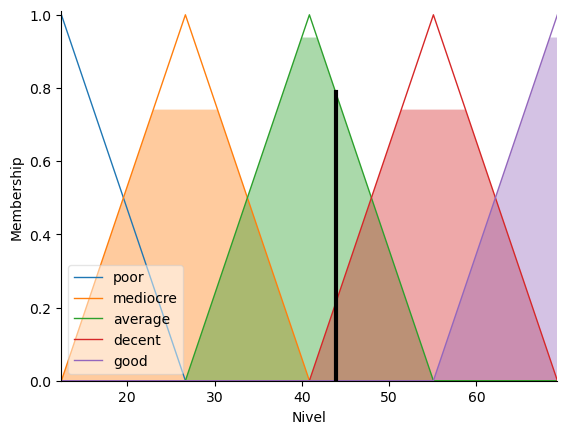

In [11]:
Ejecutar(r1, r2, r3, r4, r5, r6)